## SGNS with additional stats.

# Training word embeddings with the SGNS algorithm

In this notebook, we'll see a PyTorch implementation of a well-known training algorithm for word embeddings, Mikolov's [Skip-gram with negative sampling](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).

Please note that the example is somewhat incomplete, because in a realistic implementation we would also *save* the embeddings when training is finished. In this implementation, we'll just print the similarities to some test instances.

In [ ]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import numpy as np

import sys, time, os
from collections import Counter

If you'd like to run the code, download [this package](http://www.cse.chalmers.se/~richajo/dit865/slask/files/wikipedia_small.zip) and unzip it. [Colab users: it can be a bit difficult to download large files to the local directory in Colab, so if you have problems executing the following cell because the download gets stuck, you might need to mount a Drive directory instead.]

In [ ]:
!rm -rf wikipedia* *.zip*
!wget c/wikipedia_small.zip
!unzip wikipedia_small.zip
!ls

--2023-04-20 22:36:04--  http://www.cse.chalmers.se/~richajo/dit865/slask/files/wikipedia_small.zip
Resolving www.cse.chalmers.se (www.cse.chalmers.se)... 129.16.221.33
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.221.33|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cse.chalmers.se/~richajo/dit865/slask/files/wikipedia_small.zip [following]
--2023-04-20 22:36:04--  https://www.cse.chalmers.se/~richajo/dit865/slask/files/wikipedia_small.zip
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.221.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48419133 (46M) [application/zip]
Saving to: ‘wikipedia_small.zip’

wikipedia_small.zip 100%[===================>]  46.18M  2.77MB/s    in 2m 0s   

2023-04-20 22:38:05 (393 KB/s) - ‘wikipedia_small.zip’ saved [48419133/48419133]

Archive:  wikipedia_small.zip
   creating: wikipedia_small/
  inflating: wikipedia_small/wikipedia.txt  
sam

## Preliminaries: building the vocabulary and negative sampling table

We will first make a function that goes through the training corpus and finds the most frequent words, which will be used for the vocabulary. A special dummy token will be used as a stand-in for the words that are less frequent.

In addition, we will create the table that will be used for *negative sampling*. Each word will be sampled with a probability that is proportional to its frequency to the power of a constant (called `ns_exp` here). Sampling words randomly can be a bit tricky to implement efficiently, and we'll use a trick that was used in the `word2vec` software: we'll make a large array where each word will occur a number of times that is roughly proportional to its probability.

In [ ]:

def make_ns_table(params):
    corpus = params['corpus']
    voc_size = params['voc-size']
    ns_table_size = params['ns-table-size']
    unk_str = params['unknown-str']
    lowercase = params['lowercase']
    ns_exp = params['ns-exp']

    # This is what we'll use to store the frequencies.
    freqs = Counter()

    print('Building vocabulary and sampling table...')    

    # First, build a full frequency table from the whole corpus.
    with open(corpus) as f:
        for i, line in enumerate(f, 1):
            if lowercase:
                line = line.lower()
            freqs.update(line.split())
            if i % 50000 == 0:
                sys.stdout.write('.')
                sys.stdout.flush()
            if i % 1000000 == 0:
                sys.stdout.write(' ')
                sys.stdout.write(str(i))
                sys.stdout.write('\n')
                sys.stdout.flush()
    print()

    # Sort the frequencies, then select the most frequent words as the vocabulary.
    freqs_sorted = sorted(freqs.items(),
                          key=lambda p: (p[1], p[0]),
                          reverse=True)
    if len(freqs_sorted) > voc_size-1:
        sum_freq_pruned = sum(f for _, f in freqs_sorted[voc_size-1:])
    else:
        sum_freq_pruned = 1

    # We'll add a special dummy to represent the occurrences of low-frequency words.
    freqs_sorted = [(unk_str, sum_freq_pruned)] + freqs_sorted[:voc_size-1]

    # Now, we'll compute the negative sampling table.
    # The negative sampling probabilities are proportional to the frequencies
    # to the power of a constant (typically 0.75).
    ns_table = {}
    sum_freq = 0
    for w, freq in freqs_sorted:
        ns_freq = freq ** ns_exp
        ns_table[w] = ns_freq
        sum_freq += ns_freq

    # Convert the negative sampling probabilities to integers, in order to make
    # sampling a bit faster and easier.
    # We return a list of tuples consisting of:
    # - the word
    # - its frequency in the training data
    # - the number of positions reserved for this word in the negative sampling table
    scaler = ns_table_size / sum_freq
    return [(w, freq, int(round(ns_table[w]*scaler))) for w, freq in freqs_sorted]


And then two utility functions to load and save the negative sampling table.

In [ ]:
def load_ns_table(filename):
    with open(filename) as f:
        out = []
        for l in f:
            t = l.split()
            out.append((t[0], int(t[1]), int(t[2])))
        return out

def save_ns_table(table, filename):
    with open(filename, 'w') as f:
        for w, fr, ns in table:
            print(f'{w} {fr} {ns}', file=f)

## Generating target–context pairs

The following class is used to go through the training file line by line, and generate positive training instances (pairs consisting of a target word and a context word). Here, we will use all the preprocessing intricacies described in [Mikolov's paper](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).

The `batches` method will generate one batch at a time, containing a number of positive training instances coded as integers. The negative training instances will be created elsewhere.

In [ ]:
class SGNSContextGenerator:

    def __init__(self, ns_table, params):

        # The name of the training file.
        self.corpus = params['corpus']
        
        # The string-to-integer mapping for the vocabulary.
        self.voc = { w:i for i, (w, _, _ ) in enumerate(ns_table) }

        # The number of positive instances we'll create in each batch.
        self.batch_size = params['batch-size']

        # The maximal width of the context window.
        self.ctx_width = params['context-width']

        # Whether we should 
        self.lowercase = params['lowercase']
        
        self.word_count = 0
        
        # We define the pruning probabilities for each word as in Mikolov's paper.
        total_freq = sum(f for _, f, _ in ns_table)
        self.prune_probs = {}
        for w, f, _ in ns_table:
            self.prune_probs[w] = 1 - np.sqrt(params['prune-threshold'] * total_freq / f)

    def prune(self, tokens):
        ps = np.random.random(size=len(tokens))
        # Remove some words from the input with probabilities defined by their frequencies.
        return [ w for w, p in zip(tokens, ps) if p >= self.prune_probs.get(w, 0) ]

    def batches(self):

        widths = np.random.randint(1, self.ctx_width+1, size=self.batch_size)
        width_ix = 0

        self.word_count = 0
        
        with open(self.corpus) as f:
            out_t = []
            out_c = []
            for line in f:

                # Process one line: lowercase and split into tokens.
                if self.lowercase:
                    line = line.lower()
                tokens = line.split()
                self.word_count += len(tokens)

                # Remove some words, then encode as integers.
                encoded = [ self.voc.get(t, 0) for t in self.prune(tokens) ]

                for i, t in enumerate(encoded):

                    # The context width is selected uniformly between 1 and the maximal width.
                    w = widths[width_ix]
                    width_ix += 1

                    # Compute start and end positions for the context.
                    start = max(0, i-w)
                    end = min(i+w+1, len(encoded))

                    # Finally, generate target--context pairs.
                    for j in range(start, end):
                        if j != i:
                            out_t.append(encoded[i])
                            out_c.append(encoded[j])
                            
                            # If we've generate enough pairs, yield a batch.
                            # Each batch is a list of targets and a list of corresponding contexts.
                            if len(out_t) == self.batch_size:
                                yield out_t, out_c
                                
                                # After coming back, reset the batch.
                                widths = np.random.randint(1, self.ctx_width+1, size=self.batch_size)
                                width_ix = 0
                                out_t = []
                                out_c = []
                    
            print('End of file.')
            if len(out_t) > 0:
                # Yield the final batch.
                yield out_t, out_c

## Defining the model

Next, we implement the neural network that defines the model. The parameters just consist of two sets of embeddings: one for the target words, and one for the contexts.

The forward step is fairly trivial: we just compute the dot products of the target and context embeddings. As usual, the most annoying part is to keep track of the tensor shapes.

We also add a couple of methods that allow us to inspect the model: computing the cosine similarity between the embeddings for two words, and finding the nearest neighbor lists of a set of words.

In [ ]:
class SGNSModel(nn.Module):

    def __init__(self, voc, params):
        super().__init__()
        
        voc_size = len(voc)
        
        # Target word embeddings
        self.w = nn.Embedding(voc_size, params['emb-dim'])
        # Context embeddings
        self.c = nn.Embedding(voc_size, params['emb-dim'])
        
        # Some things we need to print nearest neighbor lists for diagnostics.
        self.voc = voc
        self.ivoc = { i:w for w, i in voc.items() }

    def forward(self, tgt, ctx):       
        # tgt is a 1-dimensional tensor containing target word ids
        # ctx is a 2-dimensional tensor containing positive and negative context ids for each target
        
        # Look up the embeddings for the target words.
        # shape: (batch size, embedding dimension)
        tgt_emb = self.w(tgt)
        
        n_batch, emb_dim = tgt_emb.shape
        n_ctx = ctx.shape[1]
        
        # View this as a 3-dimensional tensor, with
        # shape (batch size, 1, embedding dimension)
        tgt_emb = tgt_emb.view(n_batch, 1, emb_dim)

        # Look up the embeddings for the positive and negative context words.
        # shape: (batch size, nbr contexts, emb dim)
        ctx_emb = self.c(ctx)

        # Transpose the tensor for matrix multiplication
        # shape: (batch size, emb dim, nbr contexts)
        ctx_emb = ctx_emb.transpose(1, 2)

        # Compute the dot products between target word embeddings and context
        # embeddings. We express this as a batch matrix multiplication (bmm).
        # shape: (batch size, 1, nbr contexts)
        dots = tgt_emb.bmm(ctx_emb)

        # View this result as a 2-dimensional tensor.
        # shape: (batch size, nbr contexts)
        dots = dots.view(n_batch, n_ctx)

        return dots
    
    ############ [ALTERED] [0] ############
    def context_nearest_neighbors(self, words, n_neighbors):
        
        # Encode the words as integers, and put them into a PyTorch tensor.
        words_ix = torch.as_tensor([self.voc[w] for w in words])
        
        # Look up the embeddings for the test words.
        voc_size, emb_dim = self.c.weight.shape
        test_emb = self.c(words_ix).view(len(words), 1, emb_dim)

        # Also, get the embeddings for all words in the vocabulary.
        all_emb = self.c.weight.view(1, voc_size, emb_dim)

        # We'll use a cosine similarity function to find the most similar words.
        # The .view kludgery above is needed for the batch-wise cosine similarity.
        sim_func = nn.CosineSimilarity(dim=2)
        scores = sim_func(test_emb, all_emb)
        # The shape of scores is (nbr of test words, total number of words)
                
        # Find the top-scoring columns in each row.
        if not n_neighbors:
            n_neighbors = self.n_testwords_neighbors
        near_nbr = scores.topk(n_neighbors+1, dim=1)
        values = near_nbr.values[:,1:]
        indices = near_nbr.indices[:, 1:]
        
        # Finally, map word indices back to strings, and put the result in a list.
        out = []
        for ixs, vals in zip(indices, values):
            out.append([ (self.ivoc[ix.item()], val.item()) for ix, val in zip(ixs, vals) ])
        return out

    def context_cosine_similarity(self, word1, word2):        
        # We just look up the two embeddings and use PyTorch's built-in cosine similarity.
        v1 = self.c(torch.as_tensor(self.voc[word1]))
        v2 = self.c(torch.as_tensor(self.voc[word2]))
        sim = nn.CosineSimilarity(dim=0)
        return sim(v1, v2).item()

    def nearest_neighbors(self, words, n_neighbors):
        
        # Encode the words as integers, and put them into a PyTorch tensor.
        words_ix = torch.as_tensor([self.voc[w] for w in words])
        
        # Look up the embeddings for the test words.
        voc_size, emb_dim = self.w.weight.shape
        test_emb = self.w(words_ix).view(len(words), 1, emb_dim)

        # Also, get the embeddings for all words in the vocabulary.
        all_emb = self.w.weight.view(1, voc_size, emb_dim)

        # We'll use a cosine similarity function to find the most similar words.
        # The .view kludgery above is needed for the batch-wise cosine similarity.
        sim_func = nn.CosineSimilarity(dim=2)
        scores = sim_func(test_emb, all_emb)
        # The shape of scores is (nbr of test words, total number of words)
                
        # Find the top-scoring columns in each row.
        if not n_neighbors:
            n_neighbors = self.n_testwords_neighbors
        near_nbr = scores.topk(n_neighbors+1, dim=1)
        values = near_nbr.values[:,1:]
        indices = near_nbr.indices[:, 1:]
        
        # Finally, map word indices back to strings, and put the result in a list.
        out = []
        for ixs, vals in zip(indices, values):
            out.append([ (self.ivoc[ix.item()], val.item()) for ix, val in zip(ixs, vals) ])
        return out
        
        
    def cosine_similarity(self, word1, word2):        
        # We just look up the two embeddings and use PyTorch's built-in cosine similarity.
        v1 = self.w(torch.as_tensor(self.voc[word1]))
        v2 = self.w(torch.as_tensor(self.voc[word2]))
        sim = nn.CosineSimilarity(dim=0)
        return sim(v1, v2).item()


## Training

The following class contains the training loop: it creates a batch of positive target–context pairs, generates negative samples, and then updates the embedding model.

In [ ]:
class SGNSTrainer:

    def __init__(self, instance_gen, model, ns_table, params):
        self.instance_gen = instance_gen
        self.model = model
        self.n_epochs = params['n-epochs']
        self.max_words = params.get('max-words')
        n_batch = params['batch-size']
        self.n_ns = params['n-neg-samples']

        if params['optimizer'] == 'adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=params['lr'])
        elif params['optimizer'] == 'sgd':
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=params['lr'])

        # We'll use a binary cross-entropy loss, since we have a binary classification problem:
        # distinguishing positive from negative contexts.
        self.loss = nn.BCEWithLogitsLoss()

        # Build the negative sampling table.
        ns_table_expanded = []
        for i, (_, _, count) in enumerate(ns_table):
            ns_table_expanded.extend([i] * count)
        self.ns_table = torch.as_tensor(ns_table_expanded)
        
        # Define the "gold standard" that we'll use to compute the loss.
        # It consists of a column of ones, and then a number of columns of zeros.
        # This structure corresponds to the positive and negative contexts, respectively.
        y_pos = torch.ones((n_batch, 1))
        y_neg = torch.zeros((n_batch, self.n_ns))
        self.y = torch.cat([y_pos, y_neg], dim=1)

        # Some things we need to print nearest neighbor lists for diagnostics.
        #self.voc = instance_gen.voc
        #self.ivoc = { i:w for w, i in self.voc.items() }
        self.testwords = params['testwords']
        self.n_testwords_neighbors = params['n-testwords-neighbors']

        self.epoch = 0
        
    def print_test_nearest_neighbors(self):
                
        nn_lists = self.model.nearest_neighbors(self.testwords, self.n_testwords_neighbors)
        
        # For each test word, print the most similar words.
        for w, nn_list in zip(self.testwords, nn_lists):
            print(w, end=':\n')
            for nn, sim in nn_list:
                print(f' {nn} ({sim:.3f})', end='')
            print()
        
        print('------------------------------------')
        
    def make_negative_sample(self, batch_size):
        neg_sample_ixs = torch.randint(len(self.ns_table), (batch_size, self.n_ns))
        return self.ns_table.take(neg_sample_ixs)
            
    def train(self):

        ############ [ALTERED] [2] ############
        print_interval = 10000000 # 5000000
        ############ [ALTERED] [2] ############
        loss_values = [] # to store the loss values 
        
        while self.epoch < self.n_epochs:
            print(f'Epoch {self.epoch+1}.')

            # For diagnostics.
            n_pairs = 0
            sum_loss = 0
            total_pairs = 0
            n_batches = 0
            t0 = time.time()
            
            for t, c_pos in self.instance_gen.batches():

                batch_size = len(t)
                
                # Put the encoded target words and contexts into PyTorch tensors.
                t = torch.as_tensor(t)                
                c_pos = torch.as_tensor(c_pos)
                c_pos = c_pos.view(batch_size, 1)
                
                # Generate a sample of fake context words.
                # shape: (batch size, number of negative samples)
                c_neg = self.make_negative_sample(batch_size)
                
                # Combine positive and negative contexts.
                # shape: (batch size, 1 + nbr neg samples)
                c = torch.cat([c_pos, c_neg], dim=1)
                
                self.optimizer.zero_grad()

                # Compute the output from the model.
                # That is, the dot products between target embeddings
                # and context embeddings.
                scores = self.model(t, c)

                # Compute the loss with respect to the gold standard.
                loss = self.loss(scores, self.y[:batch_size])

                # Compute gradients and update the embeddings.
                loss.backward()
                self.optimizer.step()

                # We'll print some diagnostics periodically.
                sum_loss += loss.item()
                n_pairs += batch_size
                n_batches += 1
                if n_pairs > print_interval:
                    total_words = self.instance_gen.word_count
                    total_pairs += n_pairs
                    t1 = time.time()                    
                    print(f'Pairs: {total_pairs}, words: {total_words}, loss: {sum_loss / n_batches:.4f}, time: {t1-t0:.2f}')
                    ############ [ALTERED] [3] ############
                    loss_values.append(sum_loss / n_batches)
                    self.print_test_nearest_neighbors()
                    n_pairs = 0
                    sum_loss = 0
                    n_batches = 0
                    t0 = time.time()
                    
            self.epoch += 1

        ############ [ALTERED] [4] ############
        plt.plot(loss_values)
        plt.xlabel('Time')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()


## Putting all the pieces together

Now, we have all the pieces that we need to train the model. The following code just calls the other functions that we developed above. It also contains the parameters that control the program's behavior.

To keep things fast, we'll just train on a small dataset. In a realistic implementation, we'd probably use a larger dataset and also run for several epochs.

When we run this code, you will see that the similarity lists for the test words gradually start to make some sense. After an epoch, most of the lists should start to be sensible. The quality, particularly for infrequent words, will improve further if you use more training data.

Running on CUDA device.
Building vocabulary and sampling table...
.................... 1000000
..
Epoch 1.
Pairs: 10485760, words: 2890113, loss: 1.9609, time: 15.54
apple:
 hindî (0.537) omniscience (0.510) well (0.502) al-kindi (0.489) jali (0.483)
terrible:
 taishan (0.574) samaj (0.532) plains (0.526) valign (0.482) toup (0.472)
sweden:
 grounds (0.545) v (0.538) n (0.519) progress (0.513) outside (0.494)
1979:
 impossible (0.617) although (0.563) molecular (0.562) over (0.557) scholarship (0.551)
write:
 1955 (0.561) mafia (0.557) comarcas (0.553) lope (0.528) just (0.512)
gothenburg:
 vicki (0.520) stereotypical (0.519) greed (0.505) tongue-twister (0.502) .222 (0.501)
------------------------------------
Pairs: 20971520, words: 5778132, loss: 0.6932, time: 13.10
apple:
 disc (0.616) answer (0.586) indication (0.586) clay (0.584) distinguished (0.581)
terrible:
 dies (0.671) impaired (0.657) compound (0.647) professionals (0.637) saint (0.633)
sweden:
 relief (0.626) risky (0.623

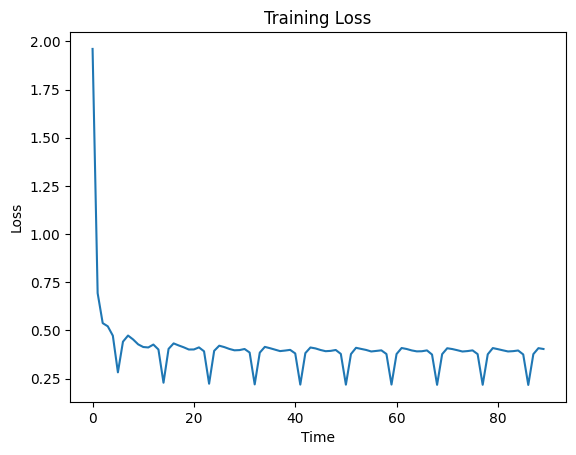

In [ ]:
model = None

def main():
    global model
    params = {
        'corpus': 'wikipedia_small/wikipedia.txt', # Training data file
        'device': 'cuda', # Device

        'n-neg-samples': 5, # Number of negative samples per positive sample
        'emb-dim': 64, # Embedding dimensionality
        
        ############ [ALTERED] [5] ############
        'n-epochs': 10, # Number of epochs
        
        'batch-size': 1<<20, # Number of positive training instances in one batch
        'context-width': 5, # Maximal possible context width
        'prune-threshold': 1e-3, # Pruning threshold (see Mikolov's paper)
        'voc-size': 100000, # Maximal vocabulary size
        'ns-table-file': 'ns_table.txt', # Where to store the negative sampling table
        'ns-table-size': 1<<24, # Size of negative sampling table
        'ns-exp': 0.75, # Smoothing parameter for negative sampling distribution (see paper)
        'unknown-str': '<UNKNOWN>', # Dummy token for low-frequency words
        'lowercase': True, # Whether to lowercase the text
        'optimizer': 'adam', # Which gradient descent optimizer to use
        'lr': 1e-1, # Learning rate for the  optimizer

        # The test words for which we print the nearest neighbors periodically
        'testwords': ['apple', 'terrible', 'sweden', '1979', 'write', 'gothenburg'],
        # Number of nearest neighbors
        'n-testwords-neighbors': 5,
    }
    
    if params['device'] == 'cuda' and torch.cuda.is_available():
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Running on CUDA device.')
    else:
        torch.set_default_tensor_type(torch.FloatTensor)
        print('Running on CPU.')

    # If we didn't already create the vocabulary and negative 
    # sampling table, we'll do that now.
    if os.path.exists(params['ns-table-file']):
        ns_table = load_ns_table(params['ns-table-file'])
    else:
        ns_table = make_ns_table(params)
        save_ns_table(ns_table, params['ns-table-file'])

    ctx_gen = SGNSContextGenerator(ns_table, params)
    model = SGNSModel(ctx_gen.voc, params)
    trainer = SGNSTrainer(ctx_gen, model, ns_table, params)

    trainer.train()
        
main()

In [ ]:
############ [ALTERED] [6] ############
# Checking if context and target embeddings are the same in the end.
mismatch_idx = []

for idx, t_emb in enumerate(model.w.weight):
  if not ( torch.equal( t_emb , model.c.weight[idx] ) ) :
    mismatch_idx.append(idx)

if len(mismatch_idx):
  print("Context and Target embeddings don't match. Mismatch on index:")
  print(mismatch_idx)
else:
  print("Context and Target embeddings match.")

Context and Target embeddings don't match. Mismatch on index:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 20

# Inspecting the result

## Closest Words
### Using target vs context embeddings

In [ ]:
model.nearest_neighbors(['plane'], 5)

[[('object', 0.6958869695663452),
  ('projection', 0.694709300994873),
  ('ramp', 0.6637498140335083),
  ('surface', 0.6620341539382935),
  ('orbit', 0.6580224633216858)]]

In [ ]:
model.context_nearest_neighbors(['plane'], 5)

[[('airplane', 0.7529703974723816),
  ('distance', 0.7403351664543152),
  ('observation', 0.7349873185157776),
  ('gravity', 0.7276605367660522),
  ('maneuver', 0.7263767719268799)]]

In [ ]:
model.nearest_neighbors(['japan'], 5)

[[('japanese', 0.781001627445221),
  ('china', 0.7146531343460083),
  ('chinese', 0.6791892051696777),
  ('korea', 0.6367151141166687),
  ('anime', 0.6347119212150574)]]

In [ ]:
model.context_nearest_neighbors(['japan'], 5)

[[('korea', 0.7662404775619507),
  ('japanese', 0.7508188486099243),
  ('china', 0.6599817276000977),
  ('asia', 0.6567063331604004),
  ('shanghai', 0.6554265022277832)]]

## Cosine similarity of given word pairs
### Target vs context embeddings

In [ ]:
model.cosine_similarity('dog', 'cat')

0.38290417194366455

In [ ]:
model.context_cosine_similarity('dog', 'cat')

0.580181360244751

In [ ]:
model.cosine_similarity('dog', 'gorilla')

0.41112861037254333

In [ ]:
model.context_cosine_similarity('dog', 'gorilla')

0.5116921067237854

## Testing Word Analogy
### Target Embeddings

In [ ]:
model.cosine_similarity('good', 'best')

0.5424380302429199

In [ ]:
model.cosine_similarity('smart', 'smartest')

0.35997718572616577

### Added Vectors

In [ ]:
word1 = "good"
word2 = "best"
v1 = model.w(torch.as_tensor(model.voc[word1])) + model.c(torch.as_tensor(model.voc[word1]))
v2 = model.w(torch.as_tensor(model.voc[word2])) + model.c(torch.as_tensor(model.voc[word2]))
sim = nn.CosineSimilarity(dim=0)
sim(v1, v2).item()

0.2889529764652252

In [ ]:
word1 = "smart"
word2 = "smartest"
v1 = model.w(torch.as_tensor(model.voc[word1]))/2 + model.c(torch.as_tensor(model.voc[word1]))/2
v2 = model.w(torch.as_tensor(model.voc[word2]))/2 + model.c(torch.as_tensor(model.voc[word2]))/2
sim = nn.CosineSimilarity(dim=0)
sim(v1, v2).item()

0.3541487455368042

## Words Similarity using SimLex and WordSim
### Using W vs W+C 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr 
from scipy.stats import spearmanr

# Load the dataset as a list of word pairs and human similarity scores
with open('SimLex-999.txt', 'r') as f:
    lines = f.readlines()
    # First row of SimLex is for name of the columns
    lines = [line.strip().split() for line in lines[1:]]
    word_pairs = [(line[0], line[1]) for line in lines]
    # SimLex similarities are [0,10], need to normalize down to [-1,1]
    human_scores = [(float(line[3]) / 10 * 2 - 1) for line in lines]

# Calculate cosine similarity with target embeddings
similarity_scores = []
for pair in word_pairs:
    try:
        word1, word2 = pair
        similarity = model.cosine_similarity(word1, word2)
        similarity_scores.append(similarity)
    except KeyError:
        similarity_scores.append(-1)

# Calculate cosine similarity with context+target embeddings
c_similarity_scores = []
for pair in word_pairs:
    try:
        word1, word2 = pair
        v1 = model.w(torch.as_tensor(model.voc[word1]))/2 + model.c(torch.as_tensor(model.voc[word1]))/2
        v2 = model.w(torch.as_tensor(model.voc[word2]))/2 + model.c(torch.as_tensor(model.voc[word2]))/2
        sim = nn.CosineSimilarity(dim=0)
        similarity = sim(v1, v2).item()
        c_similarity_scores.append(similarity)
    except KeyError:
        c_similarity_scores.append(-1)


pearson_coef, p_pearson = pearsonr(similarity_scores, human_scores)
print(f"Pearson correlation coefficient: {pearson_coef}, and p-value: {p_pearson}")

spearman_coef, p_spearman = spearmanr(similarity_scores, human_scores)
print(f"Spearman correlation coefficient: {spearman_coef}, and p-value: {p_spearman}")

print()

c_pearson_coef, c_p_pearson = pearsonr(c_similarity_scores, human_scores)
print(f"Pearson correlation coefficient for added vectors: {c_pearson_coef}, and p-value: {c_p_pearson}")

c_spearman_coef, c_p_spearman = spearmanr(c_similarity_scores, human_scores)
print(f"Spearman correlation coefficient for added vectors: {c_spearman_coef}, and p-value: {c_p_spearman}")

Pearson correlation coefficient: 0.11135968021333292, and p-value: 0.00042139719193722095
Spearman correlation coefficient: 0.1500332528300312, and p-value: 1.9060048848290288e-06

Pearson correlation coefficient for added vectors: 0.18068990873060067, and p-value: 8.855391387176106e-09
Spearman correlation coefficient for added vectors: 0.19746138039628647, and p-value: 3.065593635293712e-10


In [ ]:
# Load the dataset as a list of word pairs and human similarity scores
with open('wordsim_similarity_goldstandard.txt', 'r') as f:
    lines = f.readlines()
    lines = [line.strip().split() for line in lines]
    word_pairs = [(line[0], line[1]) for line in lines]
    # WordSim similarities are [0,10], need to normalize down to [-1,1]
    human_scores = [(float(line[2]) / 10 * 2 - 1) for line in lines]

# Calculate cosine similarity with target embeddings
similarity_scores = []
for pair in word_pairs:
    try:
        word1, word2 = pair
        similarity = model.cosine_similarity(word1, word2)
        similarity_scores.append(similarity)
    except KeyError:
        similarity_scores.append(-1)

# Calculate cosine similarity with context+target embeddings
c_similarity_scores = []
for pair in word_pairs:
    try:
        word1, word2 = pair
        v1 = model.w(torch.as_tensor(model.voc[word1]))/2 + model.c(torch.as_tensor(model.voc[word1]))/2
        v2 = model.w(torch.as_tensor(model.voc[word2]))/2 + model.c(torch.as_tensor(model.voc[word2]))/2
        sim = nn.CosineSimilarity(dim=0)
        similarity = sim(v1, v2).item()
        c_similarity_scores.append(similarity)
    except KeyError:
        c_similarity_scores.append(-1)


pearson_coef, p_pearson = pearsonr(similarity_scores, human_scores)
print(f"Pearson correlation coefficient: {pearson_coef}, and p-value: {p_pearson}")

spearman_coef, p_spearman = spearmanr(similarity_scores, human_scores)
print(f"Spearman correlation coefficient: {spearman_coef}, and p-value: {p_spearman}")

print()

c_pearson_coef, c_p_pearson = pearsonr(c_similarity_scores, human_scores)
print(f"Pearson correlation coefficient for added vectors: {c_pearson_coef}, and p-value: {c_p_pearson}")

c_spearman_coef, c_p_spearman = spearmanr(c_similarity_scores, human_scores)
print(f"Spearman correlation coefficient for added vectors: {c_spearman_coef}, and p-value: {c_p_spearman}")


Pearson correlation coefficient: 0.34582874456311785, and p-value: 4.333809842918558e-07
Spearman correlation coefficient: 0.5511210720606738, and p-value: 1.594628883539659e-17

Pearson correlation coefficient for added vectors: 0.4867221605991423, and p-value: 1.800548781329538e-13
Spearman correlation coefficient for added vectors: 0.6385638313239232, and p-value: 1.1947810943542807e-24


# Addition

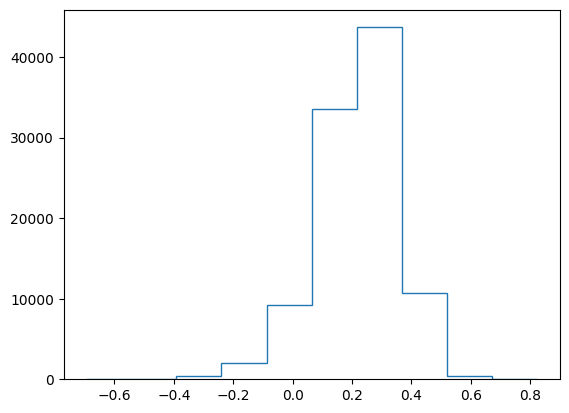

In [ ]:
similarities = []
words = list(model.voc.keys())[1:]
for w in words:
  sim = nn.CosineSimilarity(dim=0)
  similarities.append( sim( model.w(torch.as_tensor(model.voc[w])) , model.c(torch.as_tensor(model.voc[w])) ).item() )
  
counts, bins = np.histogram(similarities)
plt.stairs(counts, bins)
plt.show()

In [ ]:
from statistics import mean

mean(similarities)

0.2186344541330153

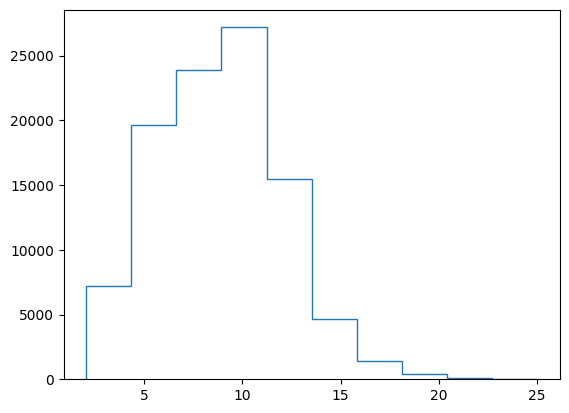

In [ ]:
distances = []
words = list(model.voc.keys())[1:]
for w in words:
  sim1 = nn.PairwiseDistance()
  distances.append(sim1( model.w(torch.as_tensor(model.voc[w])) , model.c(torch.as_tensor(model.voc[w])) ).item())
  
counts, bins = np.histogram(distances)
plt.stairs(counts, bins)
plt.show()

In [ ]:
mean(distances)

8.840923992793241

In [ ]:
model.voc.keys()

dict_keys(['<UNKNOWN>', 'the', ',', '.', 'of', 'and', 'in', 'a', 'to', '-rrb-', '-lrb-', 'is', '%', 'for', 'are', 'as', 'was', 'with', ':', 'from', 'by', '-', 'on', 'that', "'s", 'or', 'it', 'at', 'his', 'an', 'have', 'he', 'which', 'there', 'age', 'this', 'be', 'population', '--', 'also', 'has', '18', '$', 'not', 'who', 'were', 'county', ';', 'years', 'had', 'other', 'km', 'but', 'one', 'out', 'american', 'under', 'living', 'mi', '/', 'their', 'more', 'all', 'first', 'income', 'its', 'median', 'city', 'they', 'two', 'new', 'total', 'united', 'been', 'average', 'some', 'after', 'older', 'states', 'xxx', '_____', 'area', '65', 'people', 'males', 'females', 'households', 'most', 'no', 'over', 'can', "'", 'when', 'those', 'many', 'family', 'may', 'into', '2000', 'census', 'up', '_', 'line', 'time', 'made', 'such', 'used', 'every', 'see', 'them', 'only', 'world', '100', 'any', 'war', 'size', 'town', 'below', 'her', 'than', 'located', 'would', 'external', 'links', 'these', 'i', 'families', 